# Lab session 2: GPs and GP regression with GPflow 

This tutorial is adapted from the Gaussian Process Summer School that is running at the University of Sheffield since 2013. It also strongly inspired from the gpflow online documentation.

The aim of this lab session is to illustrate the concepts seen during the lectures. We will focus on three aspects of GPs: the kernel, the random sample paths and the GP regression model.

We assume that GPflow is already installed on your machine and that your are running the 1.0.0 version (or better)


In [1]:
# Do it once 
!pip install gpflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 383 kB 5.0 MB/s 
     |████████████████████████████████| 104 kB 43.3 MB/s 


In [2]:
# set up notebook

import numpy as np
import gpflow

import matplotlib
# plt = matplotlib.pyplot
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

## 1.   Getting started: The Covariance Function

There are many covariance functions (i.e. kernels) that are already implemented in gpflow, such as 

 - gpflow.kernels.Constant

 - gpflow.kernels.Linear

 - gpflow.kernels.White

 - gpflow.kernels.Matern12

 - gpflow.kernels.Matern32

 - gpflow.kernels.Matern52

 - gpflow.kernels.RBF

 - gpflow.kernels.Cosine

 - gpflow.kernels.PeriodicKernel


Let's start with a Matern 5/2 kernel:

In [4]:
k = gpflow.kernels.Matern52(variance=1., lengthscales=0.2)

A summary of the kernel can be obtained by returning the kernel in a notebook: 

In [8]:
k

name,class,transform,prior,trainable,shape,dtype,value
Matern52.variance,Parameter,Softplus,,True,(),float64,1
Matern52.lengthscales,Parameter,Softplus,,True,(),float64,0.2


Since a kernel $k(.,.)$ is a function of two inputs (plus some parameters), it is common to freeze one of the variable to a given value (say $0.5$) and to plot the kernel as a function of the remaining one:

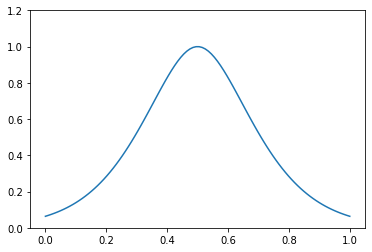

In [10]:
x_grid = np.linspace(0, 1, 100).reshape(100,1)     # get 100 points evenly spaced shaped as a column vector
plt.plot(x_grid, k(x_grid, np.array([[.5]])))
plt.ylim((0,1.2));

### Exercise 1:

a) Here is how to change the `variance` and `lengthscales` kernel parameters. What are their influence on the covariance function? 

In [11]:
k.variance.assign(0.5)
k.lengthscales.assign(1.)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=0.5413248546129181>

b) Since the kernel corresponds to the covariance between the GP values:
$$ k(x,y) = cov(Y(x), Y(y))$$
What should that imply for the GP samples?

c) plot three other covariance functions, do they all look like "hat functions"?

## 2.   Sampling from a Gaussian Process

By definition, the values taken by a GP evaluated on a grid follow a multivariate normal distribution. Given the mean function and the kernel we can evaluate them on a grid and use a multivariate normal sampler to  plot some samples.

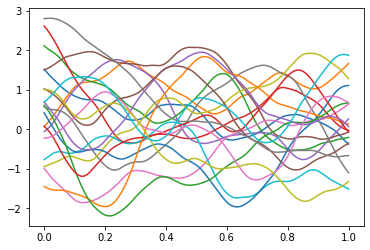

In [12]:
k = gpflow.kernels.Matern52(variance=1., lengthscales=0.2)

mu = 0 * x_grid.flatten()            # vector of the means, it is just zero here.
C = k(x_grid, x_grid)                # compute the covariance matrix associated with inputs x_grid

# Generate 20 separate samples paths from a Gaussian with mean mu and covariance C
Z = np.random.multivariate_normal(mu,C,20)

# plot them all
plt.plot(x_grid, Z.T);

### Exercise 2

a) Modify the above code to change the kernel and the mean function. What is the effect on the samples? Can you find a kernel such that the samples are continuous but not differentiable? One the other hand, can you find a kernel such that the samples are extremely smooth?

b) Investigate the influence of the kernel parameters on the samples. For example, try a lengthscale of 0.01, and a lengthscale of 10. Are the effects in line with your answer from the previous exercise? 


## 3.  A Gaussian Process Regression Model

We will now combine the Gaussian process prior with some data to form a GP regression model with GPflow. We will generate data from the function $f ( x ) = − \cos(\pi x ) + \sin(4\pi x )$ over $[0, 1]$, adding some noise to give $y(x) = f(x) + \epsilon$, with the noise being Gaussian distributed, $\epsilon \sim \mathcal{N}(0, 0.01)$.

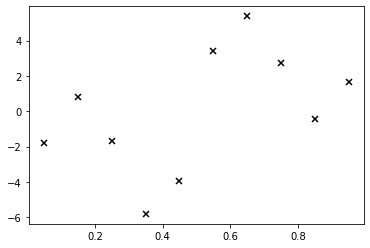

In [13]:
def test_function(x):
    y = -np.cos(np.pi*x) + np.sin(4*np.pi*x) + np.random.normal(loc=0.0, scale=0.1, size=x.shape) 
    return(4*y)

X = np.linspace(0.05, 0.95, 10).reshape(10, 1)
Y = test_function(X)

plt.plot(X, Y, 'kx', mew=1.5)

We are now going to reconstruct an approximation of the test function using only this data, and the prior knowledge that the function is very smooth (i.e. infinitely differentiable).

### Exercise 3

a) What kernel would you suggest in order to account for this prior knowledge? 

b) Similarly, can you hand pick reasonable values for the `variance` and `lengthscales` for this problem? 

c) Update the lines below accordingly.

In [ ]:
k = gpflow.kernels.Matern32(input_dim=1, variance=1., lengthscales=.2)
k.lengthscales = 1.
k.variance = 0.5

Creating a GP regression model is then quite simple:

In [15]:
m = gpflow.models.GPR((X, Y), kernel=k)
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.2
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1


Now, let's plot our model predictions!

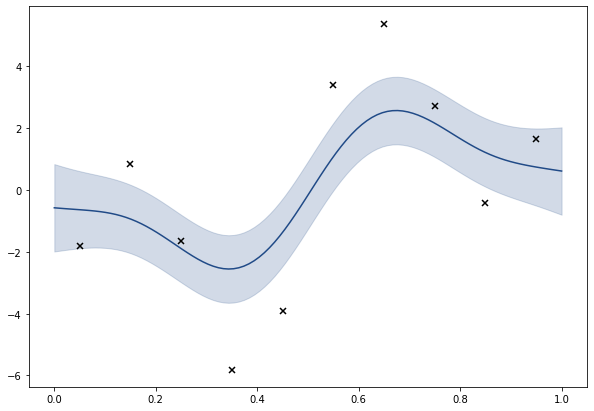

In [17]:
def plot(x_grid, m):
    mean_pred, var_pred = m.predict_f(x_grid)
    upper_95 = mean_pred + 2*np.sqrt(var_pred)
    lower_95 = mean_pred - 2*np.sqrt(var_pred)

    plt.figure(figsize=(10,7))
    plt.plot(x_grid, mean_pred, color='#204a87')
    plt.fill_between(x_grid[:,0], lower_95[:,0], upper_95[:,0], color='#204a87', alpha=.2)
    plt.plot(*m.data, 'kx', mew=1.5);

plot(x_grid, m)

The prediction variance is quite wrong on this example! The next exercise is about setting it right.

### Exercise 4

*a)* By default, the noise variance is set to 1 when the model is created. You can modify this by assigning a new value by running `m.likelihood.variance.assign(0.1)`. Can you tweak this parameter to obtain a more sensible model?

*b)* What happen to the model predition if you change the kernel paramerers (you can directly assign values to `m.kern.variance` and `m.kern.lengthscales`)? Is that in accordance with your answers from Ex 2.b? 

As we have seen previously, generating samples from a GP requires the vector corresponding to the mean function and the covariance matrix. The first one is already computed as `mean_pred`, but `var_pred` is only a vector of the variance values and not the full covariance matrix. 

*c)* Use the `m.predict_f_full_cov` function to obtain the full covariance matrix. Generate and plot samples from the posterior distribution.

## 4.  Covariance Function Parameter Estimation

As we have seen during the course, the parameters values can be estimated by maximizing the likelihood of the observations. Since we don’t want one of the variance to become negative during the optimization, the parameteres are by default constrained to be positive:

In [18]:
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.2
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1


Now we can optimize the model:

In [24]:
gpflow.optimizers.Scipy().minimize(m.training_loss_closure(), m.trainable_variables)

## print m
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,13.0211
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.135285
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.50056e-06


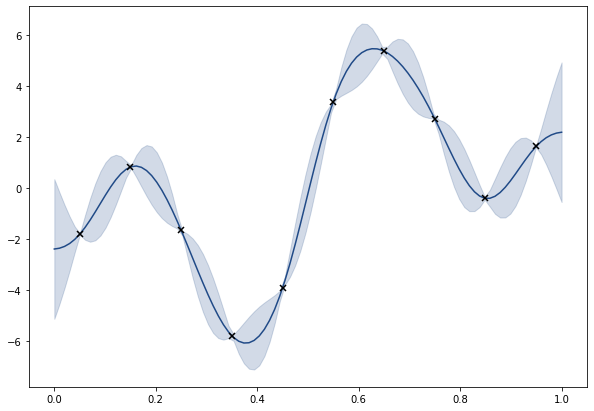

In [25]:
plot(x_grid, m)

## 5. Computing the mean value of the test function

In this section, we will see that using the GP model leads to more accurate predictions than if we where to use only the raw data. We will focus here on one particular quantity to predict: the average value of the test function (i.e. its ingregral). Since this is a toy example, calculus can show that this average value is exactly 0. 

Monte-Carlo is the cannonical method for approximating average values. It consists in taking the average value of a very large number of data points with inputs distributed uniformly:

0.026401766939540442

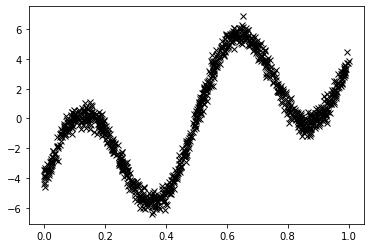

In [28]:
X = np.random.uniform(0, 1, (1000,1))
Y = test_function(X)

plt.plot(X.T, Y.T, 'kx')
np.mean(Y)

We can see that the result is approximated pretty well but we had to use 1000 datapoints! In practice, it is often the case that the number of data points is limited. Let's see if we can retreive this value with only 20 observations of the function:

0.5145530645575956

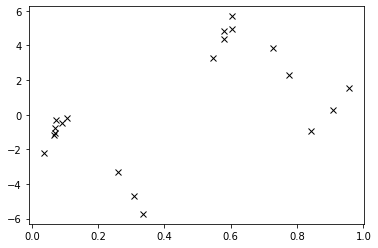

In [29]:
X = np.random.uniform(0, 1, (20,1))
Y = test_function(X)

plt.plot(X.T, Y.T, 'kx')
np.mean(Y)

The quality of the approximation is definitely not as good as before. On the other hand, we can use those 20  points to build a GP regression model and then approximate the average value of the test function by the average value of the posterior mean:

0.003022927734399752

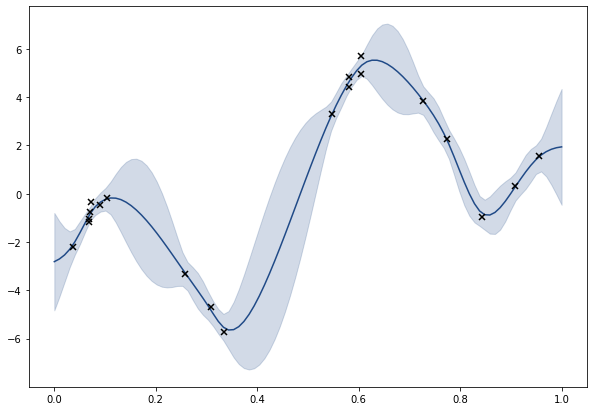

In [31]:
k = gpflow.kernels.Matern32(variance=1., lengthscales=.2)

m = gpflow.models.GPR((X, Y), k)

gpflow.optimizers.Scipy().minimize(m.training_loss_closure(), m.trainable_variables)

plot(x_grid, m)

mean_pred, var_pred = m.predict_f(x_grid)
np.mean(mean_pred)

### Exercise 5

*a)* Which of the two methods based on 20 data points seems to return a value closest to the target? Can you tell why?

*b)* For now we have only used the mean prediction and not the uncertainty that is also provided by the model. To properly quantify the uncertainty, we can generate samples from the conditional distribution and then compute the average value of the samples. This average value will be random since it is based on a random sample paths and it is possible to compute its mean and variance. Can you write the code that does so?

*c)* (advanced) In this case, the distribution of the average values of the samples can be computed analytically using the linearity of the expectation and the covariance. Give it a shot if you want to!


## Further exercises: Combining Covariance Functions

In GPflow you can easily combine covariance functions you have created using the sum and product operators, `+` and `*`. So, for example, if we wish to combine an exponentiated quadratic covariance with a Matern 5/2 then we can write

In [26]:
kern1 = gpflow.kernels.RBF(variance=1., lengthscales=2.)
kern2 = gpflow.kernels.Matern52(variance=2., lengthscales=4.)
kern = kern1 + kern2

kern

name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Sum.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,2
Sum.kernels[1].variance,Parameter,Softplus,,True,(),float64,2
Sum.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,4


Or if we wanted to multiply them we can write

In [27]:
kern = kern1 * kern2

kern

name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,2
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,2
Product.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,4


### Exercise 5

a) Generate samples from the above kernels. 

b) Can you build a kernel such that the samples look similar to the following plots?

![samples to replicate](https://github.com/mlss-2019/tutorials/blob/master/gaussian_processes/img/mystery_samples.png?raw=1)